<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

### 1. Данные (0.5 балла)

In [23]:
!python3.9 -m pip install gdown


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
# Скачайте датасет по ссылке https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing

#!gdown --id 1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO

In [25]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: total: 3.5 s
Wall time: 7.71 s



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [26]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [27]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [28]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for img_captions in captions:
    for caption in img_captions:
        word_counts.update(caption)

print(f"Total unique words: {len(word_counts)}")

Total unique words: 29416


In [29]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [30]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [31]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [32]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [33]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors).unsqueeze(0)
        initial_hid = self.cnn_to_h0(image_vectors).unsqueeze(0)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_hid, initial_cell))

        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits

In [34]:
network = CaptionNet(n_tokens)

In [35]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [36]:
def compute_loss(network, image_vectors, captions_ix, pad_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)


    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = nn.functional.cross_entropy(
        logits_for_next.view(-1, logits_for_next.shape[-1]), 
        captions_ix_next.view(-1),
        ignore_index=pad_ix
    )

    return loss

In [37]:
pad_ix = word_to_index['#PAD#']
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix, pad_ix)

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'


Добавьте ~~adam~~ ваш любимы оптимизатор для обучения.

In [38]:
optimizer = torch.optim.Adagrad(network.parameters(), lr=0.01)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [39]:
from sklearn.model_selection import train_test_split
#captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [40]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image
    captions_for_batch_images = [captions[i] for i in random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)


In [41]:
generate_batch(img_codes,captions,3)

(tensor([[0.0466, 0.2322, 0.1764,  ..., 0.0328, 0.0634, 0.2510],
         [0.4889, 0.1142, 0.9692,  ..., 0.0784, 1.2990, 0.2572],
         [0.6323, 0.1063, 0.5544,  ..., 0.2368, 0.7343, 0.2847]]),
 tensor([[   1,  524,  584,   28,   24, 7917,  878,   97,  136, 3471,   12,    2,
             3],
         [   1, 1312, 1149,   15,   24,  693,   94,  248, 2771,   14,   24,  268,
             2],
         [   1,   24,  439,   14,  198,  310,  779,  924,   24, 1223,   12,    2,
             3]]))

Обучайте модель на мини-батчах, как обычно. Периодически проверяйте качество на валидационном наборе.

#### **Советы**

* Если тренировочный лосс почти равен нулю или модель генерирует бессмысленный текст — проверьте, что вы предсказываете следующее слово, а не текущее или слово через два шага.

* Если модель создаёт плавные, но нерелевантные описания:

  * возможно, рекуррентная сеть не получает векторы изображения;

  * также это может быть следствием взрыва градиентов — попробуйте клиппинг или перезапуск обучения;

  * наконец, возможно, модель просто нужно обучить дольше.

* Кросс-энтропия — слабый показатель переобучения:

  * модель может переобучиться по валидационной кросс-энтропии, но при этом продолжать улучшать качество генерации;

  * используйте ручную оценку или автоматические метрики, такие как CIDEr или BLEU.

* Рекомендуется периодически проверять сеть с помощью блока “apply trained model” — можно остановить обучение, протестировать несколько примеров и продолжить.

* Типичные значения функции потерь: около 3–5, если усреднять по времени,
или масштабировать по длине при суммировании. Разумные подписи начинают появляться при лоссе 2.8–3.0.

In [42]:
batch_size = 64  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 7  # how many batches are used for validation after each epoch

In [43]:
network = CaptionNet(n_tokens, 256, 512)
optimizer = torch.optim.Adagrad(network.parameters(), lr=0.01)

In [44]:
from tqdm import tqdm

pad_ix = word_to_index['#PAD#']


for epoch in range(n_epochs):

    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size), pad_ix)


        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        #torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    with torch.no_grad():
        for _ in range(n_validation_batches):
            loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size), pad_ix)
            val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:12<00:00,  3.90it/s]



Epoch: 0, train loss: 4.632925696372986, val loss: 4.021372624805996


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]



Epoch: 1, train loss: 3.9060181951522828, val loss: 3.8600631781986783


100%|██████████| 50/50 [00:13<00:00,  3.84it/s]



Epoch: 2, train loss: 3.730253186225891, val loss: 3.561398506164551


100%|██████████| 50/50 [00:29<00:00,  1.70it/s]



Epoch: 3, train loss: 3.5847200536727906, val loss: 3.4925545624324252


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]



Epoch: 4, train loss: 3.5128741025924684, val loss: 3.3995188644954135


100%|██████████| 50/50 [00:31<00:00,  1.58it/s]



Epoch: 5, train loss: 3.363746361732483, val loss: 3.3858628613608226


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]



Epoch: 6, train loss: 3.3211039161682128, val loss: 3.2749507427215576


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]



Epoch: 7, train loss: 3.2426023960113524, val loss: 3.316421236310686


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]



Epoch: 8, train loss: 3.23901273727417, val loss: 3.2888007504599437


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]



Epoch: 9, train loss: 3.214101495742798, val loss: 3.250671182359968


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]



Epoch: 10, train loss: 3.153390951156616, val loss: 3.1909144946507046


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]



Epoch: 11, train loss: 3.1220589590072634, val loss: 3.0779153960091725


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]



Epoch: 12, train loss: 3.12807409286499, val loss: 2.9680300780705045


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]



Epoch: 13, train loss: 3.0359436655044556, val loss: 3.060522896902902


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]



Epoch: 14, train loss: 3.033503041267395, val loss: 3.0784049374716624


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]



Epoch: 15, train loss: 3.0348863554000856, val loss: 2.972902570452009


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]



Epoch: 16, train loss: 3.0059616327285767, val loss: 3.0603409835270474


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]



Epoch: 17, train loss: 3.016427788734436, val loss: 2.930068152291434


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]



Epoch: 18, train loss: 2.9884620618820192, val loss: 3.0916737147739957


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]



Epoch: 19, train loss: 2.9541663932800293, val loss: 3.0059209210532054


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]



Epoch: 20, train loss: 2.911071734428406, val loss: 2.9703097684042796


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]



Epoch: 21, train loss: 2.946306920051575, val loss: 2.8126490456717357


100%|██████████| 50/50 [00:36<00:00,  1.39it/s]



Epoch: 22, train loss: 2.898621129989624, val loss: 2.8956092425755093


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]



Epoch: 23, train loss: 2.8920407342910766, val loss: 2.932324375425066


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]



Epoch: 24, train loss: 2.886551604270935, val loss: 2.9446800436292375


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]



Epoch: 25, train loss: 2.8861869382858276, val loss: 2.9148189340318953


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]



Epoch: 26, train loss: 2.8636308765411376, val loss: 2.828735726220267


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]



Epoch: 27, train loss: 2.8264400482177736, val loss: 2.920020648411342


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]



Epoch: 28, train loss: 2.815159034729004, val loss: 2.8188656057630266


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]



Epoch: 29, train loss: 2.8185799074172975, val loss: 2.9123757566724504


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]



Epoch: 30, train loss: 2.8267227602005005, val loss: 2.8471294471195767


100%|██████████| 50/50 [00:14<00:00,  3.51it/s]



Epoch: 31, train loss: 2.806324520111084, val loss: 2.788789817265102


100%|██████████| 50/50 [00:14<00:00,  3.56it/s]



Epoch: 32, train loss: 2.8208542966842653, val loss: 2.827152592795236


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]



Epoch: 33, train loss: 2.7879073238372802, val loss: 2.819587094443185


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]



Epoch: 34, train loss: 2.7739238357543945, val loss: 2.8134408678327287


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]



Epoch: 35, train loss: 2.7898479461669923, val loss: 2.9328835010528564


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]



Epoch: 36, train loss: 2.759562611579895, val loss: 2.7545640809195384


100%|██████████| 50/50 [00:13<00:00,  3.74it/s]



Epoch: 37, train loss: 2.770023612976074, val loss: 2.7716186387198314


100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



Epoch: 38, train loss: 2.779728102684021, val loss: 2.78314665385655


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]



Epoch: 39, train loss: 2.7362673568725584, val loss: 2.753443649836949


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]



Epoch: 40, train loss: 2.746661944389343, val loss: 2.851337194442749


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]



Epoch: 41, train loss: 2.7321782636642458, val loss: 2.740126064845494


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]



Epoch: 42, train loss: 2.7242741775512695, val loss: 2.7349637235913957


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]



Epoch: 43, train loss: 2.742552080154419, val loss: 2.6506122861589705


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]



Epoch: 44, train loss: 2.749173812866211, val loss: 2.7921769618988037


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]



Epoch: 45, train loss: 2.71805944442749, val loss: 2.7533886432647705


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]



Epoch: 46, train loss: 2.69775351524353, val loss: 2.673546246119908


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]



Epoch: 47, train loss: 2.7285441398620605, val loss: 2.73549975667681


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]



Epoch: 48, train loss: 2.6945342206954956, val loss: 2.687896353857858


100%|██████████| 50/50 [00:13<00:00,  3.77it/s]



Epoch: 49, train loss: 2.716030616760254, val loss: 2.762712001800537


100%|██████████| 50/50 [00:14<00:00,  3.35it/s]



Epoch: 50, train loss: 2.6791121625900267, val loss: 2.700613226209368


100%|██████████| 50/50 [00:15<00:00,  3.27it/s]



Epoch: 51, train loss: 2.6921888732910157, val loss: 2.635063035147531


100%|██████████| 50/50 [00:14<00:00,  3.47it/s]



Epoch: 52, train loss: 2.6954186153411865, val loss: 2.8112478937421526


100%|██████████| 50/50 [00:12<00:00,  3.91it/s]



Epoch: 53, train loss: 2.6863523530960083, val loss: 2.716848611831665


100%|██████████| 50/50 [00:12<00:00,  4.02it/s]



Epoch: 54, train loss: 2.65955539226532, val loss: 2.6656616755894254


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]



Epoch: 55, train loss: 2.667395844459534, val loss: 2.70299346106393


100%|██████████| 50/50 [00:12<00:00,  3.88it/s]



Epoch: 56, train loss: 2.6803357887268064, val loss: 2.7594921248299733


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]



Epoch: 57, train loss: 2.7065278625488283, val loss: 2.737949882234846


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]



Epoch: 58, train loss: 2.6649671936035157, val loss: 2.72561468396868


100%|██████████| 50/50 [00:20<00:00,  2.44it/s]



Epoch: 59, train loss: 2.679419960975647, val loss: 2.679432221821376


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]



Epoch: 60, train loss: 2.6756285047531128, val loss: 2.7086354664393832


 88%|████████▊ | 44/50 [00:11<00:01,  3.77it/s]


KeyboardInterrupt: 

### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [45]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [46]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t)

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

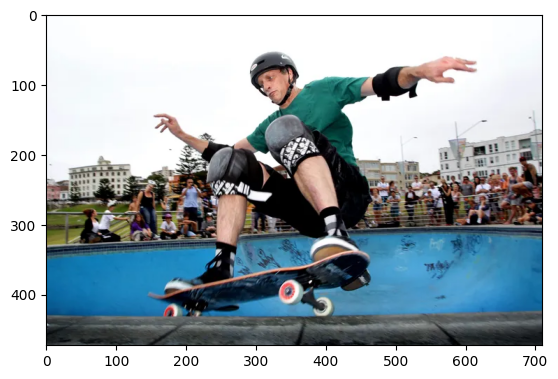

In [47]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

def imresize(img_in, size):
    return np.array(Image.fromarray(img_in).resize(size))

#sample image
#!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
plt.imshow(img)
img = imresize(img, (299, 299)).astype('float32') / 255.

In [48]:
for i in range(10):
    print(' '.join(generate_caption(img, t=2.)[1:-1]))

a man in a black wetsuit holding a surfboard .
a man doing a trick on a skateboard .
a man on a skateboard is doing a trick .
a man riding a skateboard down a ramp .
a man is riding a skateboard on a ramp .
a person is jumping off on a skateboard .
a man with a helmet is riding a skateboard .
a man riding a skateboard down a ramp .
a skateboarder doing a trick on a skateboard .
a skateboarder is doing a trick on a skateboard .


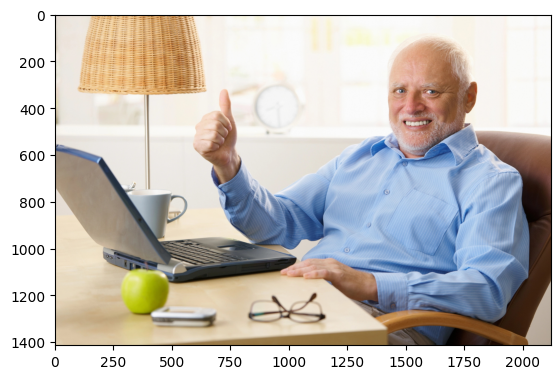

a man is sitting at a laptop computer .
a man is sitting at a laptop computer .
a man is sitting at a laptop computer .
a man is sitting at a table with a laptop .
a man is sitting at a desk with a laptop computer .
a man is sitting on a laptop computer .
a man is sitting at a table with a laptop .
a man is sitting at a table with a laptop computer .
a man in a suit is holding a laptop .
a man is sitting at a laptop computer .


In [49]:
#!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img1.jpg')

plt.imshow(img)
plt.show()

img = imresize(img, (299, 299)).astype('float32') / 255.

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

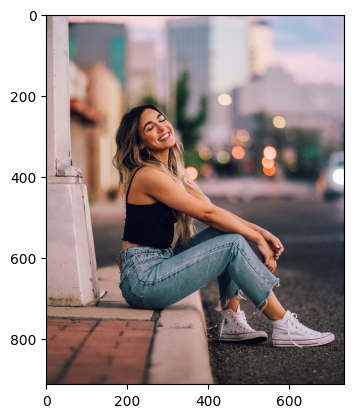

a man sitting on a bench with a skateboard .
a man sitting on a bench with a skateboard .
a man is sitting on a bench with a skateboard .
a young boy sitting on a bench in a park .
a woman sitting on a bench with a cell phone .
a woman sitting on a bench with a laptop .
a woman sitting on a bench with a laptop .
a woman sitting on a bench with a dog .
a woman sitting on a bench with a laptop .
a woman sitting on a bench with a cell phone .


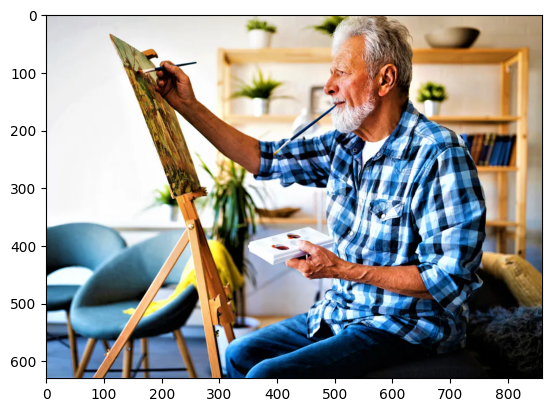

a woman sitting on a bench with a cell phone .
a woman and a child are sitting on a bench .
a man and woman are sitting on a bench .
a woman is sitting on a bench with a laptop .
a woman is sitting on a bench with a laptop .
a woman sitting on a bench with a cell phone .
a man sitting on a bench with a cell phone
a man is sitting on a bench with a dog .
a man is sitting on a bench in the grass .
a woman in a blue shirt is sitting on a bench .


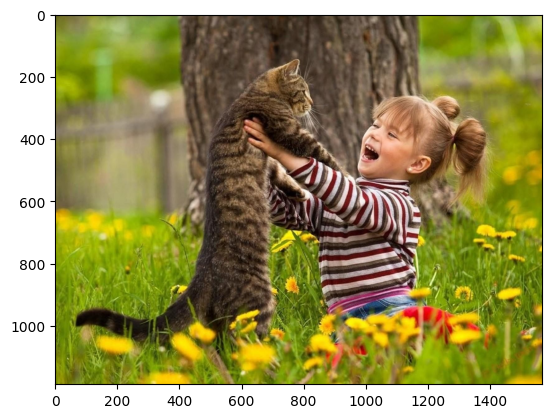

a giraffe is standing in the grass next to a tree .
a baby giraffe is standing in a field .
a giraffe is standing in a field of grass .
a baby giraffe is standing in a field of grass .
a baby giraffe is standing in the grass .
a giraffe standing in a field with a frisbee in its mouth .
a baby giraffe standing on a lush green field .
a baby giraffe is standing in a field .
a young boy holding a baby elephant on a field .
a baby giraffe is standing on a tree branch .


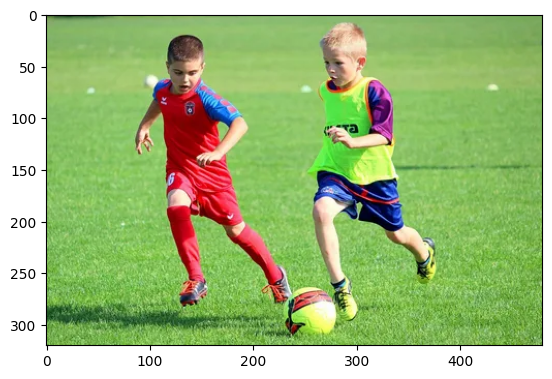

a group of people playing a game of soccer .
a young boy playing with a soccer ball .
a group of people playing a game of soccer .
a man is playing frisbee on a field .
a man is playing frisbee in the grass .
a young boy is playing frisbee in a field .
a young boy is playing frisbee in the grass .
a young boy is playing with a soccer ball .
a young boy is playing frisbee in a field
a young boy is playing soccer in a field .


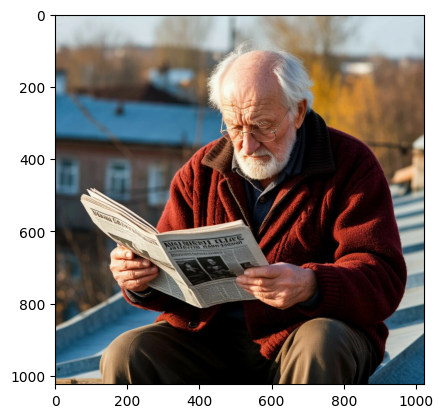

a man with a hat and a hat on a table .
a man sitting at a table with a laptop .
a man is sitting on a bench with a laptop .
a man with a hat and a hat on a table .
a man is holding a cell phone on a table .
a man holding a cell phone while sitting on a table .
a man holding a cell phone while sitting on a table .
a man holding a cell phone in front of a laptop .
a man is holding a cell phone while sitting on a table .
a man holding a cell phone while sitting on a table .


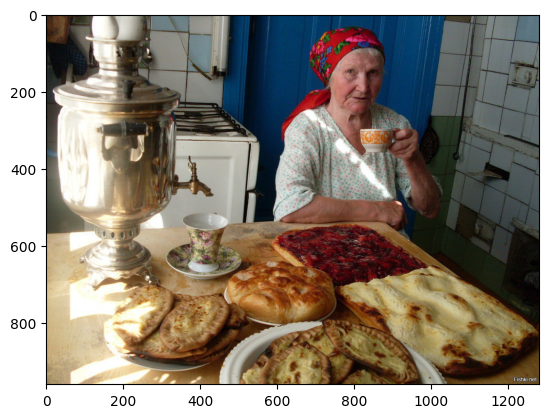

a woman is eating pizza in a pan .
a woman is sitting at a table with a pizza .
a man and a woman sitting at a table with a pizza .
a woman sitting at a table with a pizza .
a woman holding a pizza on top of a pizza .
a woman is eating pizza on a table .
a woman is sitting at a table with a pizza .
a woman is sitting at a table with a pizza .
a woman sitting at a table with a pizza on it .
a man is eating a pizza on a plate .


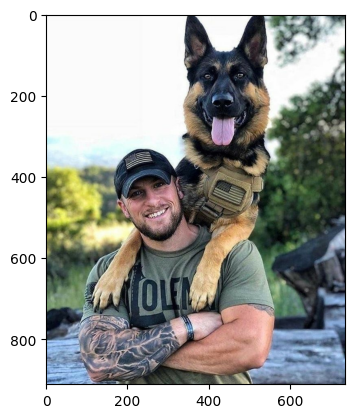

a man is holding a frisbee in his mouth .
a man with a hat and a dog on a leash .
a man is sitting on a bench in the grass .
a man with a hat is standing on a beach .
a man with a hat and a dog on a leash .
a man with a hat and a dog on a beach .
a man is sitting on a bench with a dog .
a man is holding a frisbee in his mouth .
a man is sitting on a bench with a dog .
a man with a hat is standing on a grass covered field .


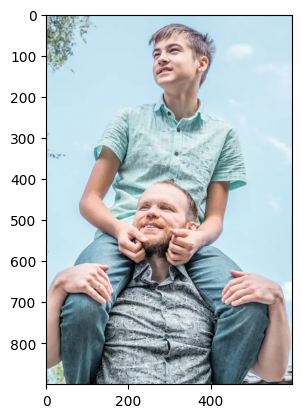

a man and a woman are sitting on a bench .
a man and woman are sitting on a bench .
a man is sitting on a bench with a dog .
a man and woman are sitting on a bench .
a man and a woman are sitting on a bench .
a woman is sitting on a bench with a dog .
a man and a woman are sitting on a bench .
a man is sitting on a bench in a room .
a man and woman are sitting on a bench .
a woman sitting on a bench with a dog .


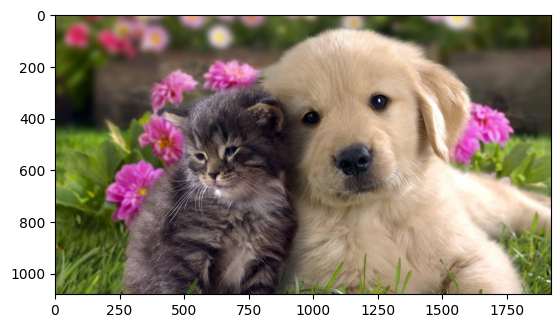

a brown dog laying on top of a wooden table .
a dog with a hat and a red hat .
a dog laying on a bed with a blanket .
a dog sitting on a couch with a stuffed animal .
a small dog is laying on a blanket .
a brown dog laying on top of a wooden table .
a brown dog laying on top of a wooden table .
a brown dog laying on top of a wooden table .
a brown dog sitting on a chair with a dog .
a brown and white dog laying on a blanket .


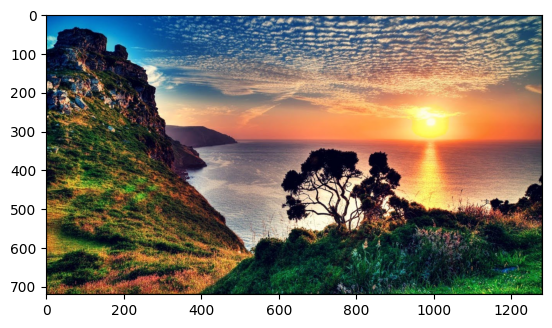

a man is flying a kite in the water .
a man is standing on a beach with a surfboard .
a large group of people standing on a beach .
a large body of water with a large bird on it .
a large body of water with a large body of water .
a large group of people standing on a beach .
a large body of water with a large body of water .
a large body of water with a large body of water .
a small boat is on the beach with a large body of water .
a man is riding a surfboard on a beach .


In [53]:
# apply your network on images you've found

for j in range(1, 11):
    img = plt.imread(f'img1/{j}.jpg')

    plt.imshow(img)
    plt.show()

    img = imresize(img, (299, 299)).astype('float32') / 255.

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))

Выводы:
В целом, модель работает неплохо: распознаёт основные объекты на изображении (людей и животных). Часто путает мужчин и женщин, но это не кажется критичным. Не распозначло котёнка, близко расположенного к собаке. На изображении с пейзажем увидела человека, которого там не было. На изображении с пирогами на столе увидело пиццу, а газету распознало как ноутбук или телефон, что, вероятно, связано с обучающими данными.


![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

> Примечание: Это задание адаптировано по материалам курса "Deep Learning" (Skoltech).
